In [1]:
import torch
from torch import nn, optim, Tensor
from datasets import load_dataset, load_dataset_builder
from torch.utils.data import DataLoader, default_collate, Dataset
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
ds = load_dataset("segments/sidewalk-semantic",data_dir="./data")

Found cached dataset parquet (/home/shubham/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-313972844435cffe/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
dataset = ds["train"]
print(len(dataset))

1000


In [4]:
x,y = dataset.features
num_classes = 35

In [5]:
train_split = 0.8

train_ds, valid_ds = torch.utils.data.random_split(dataset,[int(train_split*len(dataset)), len(dataset)- int(train_split*len(dataset))])

In [6]:
print(len(train_ds), len(valid_ds))

800 200


In [7]:
train_ds[0:4]

{'pixel_values': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>],
 'label': [<PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>]}

In [8]:
class myDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, i):
        if isinstance(i, int):
            return TF.to_tensor(self.dataset[i][x]) , TF.to_tensor(self.dataset[i][y])
        images = self.dataset[i][x]
        images = [TF.to_tensor(o) for o in images]
        images = torch.stack(images)
        labels = self.dataset[i][y]
        labels = [TF.to_tensor(o) for o in labels]
        labels = torch.stack(labels)
        return images, labels

In [9]:
train_ds = myDataset(train_ds)
valid_ds = myDataset(valid_ds)

BATCH_SIZE = 4

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

torch.Size([4, 3, 1080, 1920]) torch.Size([4, 1, 1080, 1920])


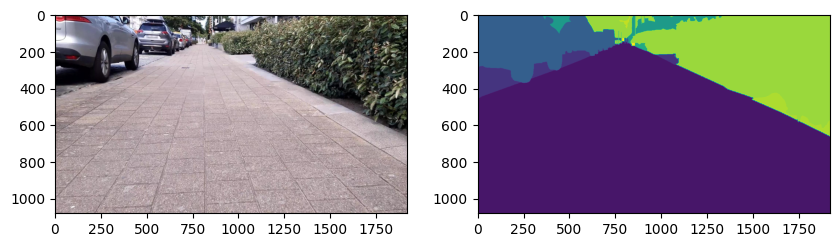

In [10]:
# Let's see what the data looks like

batch = next(iter(train_dl))
images, labels = batch

print(images.shape, labels.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[0].permute(1,2,0))
ax[1].imshow(labels[0].permute(1,2,0))
plt.show()

In [11]:
# Let's define the model

class SegmentationModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.upsample(self.upsample(x))
        x = self.softmax(x)
        return x

In [12]:
model = SegmentationModel(3, num_classes)

In [13]:
batch = next(iter(train_dl))
images, labels = batch
preds = model(images)
print(preds.shape)

torch.Size([4, 35, 1080, 1920])


In [14]:
lr = 1e-3
epochs = 5
opt = optim.Adam(model.parameters(), lr=lr, eps = 1e-5)
sched = optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epochs, steps_per_epoch=len(train_dl))
criterion = nn.CrossEntropyLoss()

In [17]:
def fit(model, epochs, opt, sched, criterion, train_dl, valid_dl):
    for epoch in range(epochs):
        tot_loss,tot_acc,count = 0.,0.,0
        model.train()
        for images, labels in tqdm(train_dl, total=len(train_dl)):
            labels = labels.squeeze(1)
            preds = model(images)
            print(preds.shape, labels.shape)
            loss = criterion(preds, labels)
            n = len(images)
            count += n
            tot_loss += loss.item()*n
            tot_acc  += (preds.argmax(dim=1)==labels).float().mean().item()*n
            loss.backward()
            opt.step()
            opt.zero_grad()
            sched.step()
        print(f"Epoch {epoch} - Training Loss: {tot_loss/count} - Training Accuracy: {tot_acc/count}")
        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for images, labels in tqdm(valid_dl, total=len(valid_dl)):
                preds = model(images)
                n = len(images)
                count += n
                tot_loss += criterion(preds,labels).item()*n
                tot_acc  += (preds.argmax(dim=1)==labels).float().mean().item()*n
        print(f"Epoch {epoch} - Validation Loss: {tot_loss/count} - Validation Accuracy: {tot_acc/count}")

In [18]:
fit(model, epochs, opt, sched, criterion, train_dl, valid_dl)

  0%|          | 0/200 [00:00<?, ?it/s]

: 

: 